In [ ]:
!pip install casadi scipy tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 13.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from scipy.interpolate import interp1d
from numpy.linalg import svd
import casadi as ca
from concurrent.futures import ProcessPoolExecutor
import pandas as pd

In [ ]:
# === Model configuration for SSF case study ===
nx = 8            # Number of state variables:
                 # [0] Xa  - Active biomass (not measured)
                 # [1] U   - Urea
                 # [2] NI  - Nitrogen intermediate (not measured)
                 # [3] Xm  - Measured biomass
                 # [4] CO2 - Carbon dioxide
                 # [5] O2  - Oxygen
                 # [6] GA3 - Product (GA3)
                 # [7] S   - Substrate

nth = 14          # Number of parameters used in the model
Tf = 125          # Final integration time [h], based on experimental data duration
Nt = 101         # Number of time evaluation points (can match number of data points or be higher)
t_eval = np.linspace(0, Tf, Nt)  # Time vector for integration

# === Symbolic variables for states and parameters ===
x = ca.MX.sym("x", nx)         # State vector: [Xa, U, NI, Xm, CO2, O2, GA3, S]
theta = ca.MX.sym("theta", nth)

# === Unpack parameters ===
mun, kd, ku, mco2, mo2, kp, yxn, kn, yxco2, yxo2, betam, ki, yxs, ms = theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], theta[6], theta[7], theta[8], theta[9], theta[10], theta[11], theta[12], theta[13]

# === Algebraic expressions ===
mu = mun * x[2] / (kn + x[2])                # Specific growth rate
beta = betam / (1 + ki * x[2])              # GA3 production rate

# === Model equations (xdot) ===
xdot = ca.vertcat(
    mu * x[0] - kd * x[0],                                    # x[0] Xa
    ca.if_else(x[1] > 0, -ku, 0),                             # x[1] U
    ca.if_else(x[1] > 0, 0.47 * ku - mu * x[0] / yxn, -mu * x[0] / yxn),  # x[2] NI
    mu * x[0],                                                # x[3] Xm
    mu * x[0] / yxco2 + mco2 * x[0],                          # x[4] CO2
    mu * x[0] / yxo2 + mo2 * x[0],                            # x[5] O2
    beta * x[0] - kp * x[6],                                  # x[6] GA3
    -mu * x[0] / yxs - ms * x[0]                              # x[7] S
)

# === Initial conditions as parameters (optional) ===
# You may keep these external, or define them as part of optimization later.
x0 = ca.MX.sym("x0", nx)

# === Nominal parameter values  ===
theta_nom = np.array([
    0.3, 0.05, 5e-3, 0.2, 0.1, 0.0,
    16.0, 3e-3, 3.3, 17.0, 6e-4, 2e3,
    0.17, 0.05
])

# === Symbolic derivatives for extended system ===
dfdx = ca.jacobian(xdot, x)        # ∂f/∂x → Jacobian wrt states
dfdth = ca.jacobian(xdot, theta)   # ∂f/∂θ → Jacobian wrt parameters

# === CasADi function wrappers ===
f = ca.Function("f", [x, theta], [xdot])
dfdx_fun = ca.Function("dfdx", [x, theta], [dfdx])
dfdth_fun = ca.Function("dfdth", [x, theta], [dfdth])

# === Fixed initial conditions ===
u0 = 3.146 / 1000
s0 = 1.768685 / 10
x0_val = np.array([0.006878, u0, 0, 0.006878,
                   0.00885, 0.00467, 0, s0])

dx0_val = np.zeros((nx, nth))  # Sensitivities of x0 w.r.t. theta are zero

# === Extended system: sensitivity ODEs ===
def meta_rhs(t, x_ext, theta_val):
    x = x_ext[:nx]
    dx_dth = x_ext[nx:].reshape((nx, nth))
    A = np.array(dfdx_fun(x, theta_val))
    B = np.array(dfdth_fun(x, theta_val))
    dx = np.array(f(x, theta_val)).flatten()
    d_dx_dth = A @ dx_dth + B
    return np.concatenate([dx, d_dx_dth.flatten()])

# === Forward integration of state and sensitivities ===
def simulate_once(theta_val):
    x0_ext = np.concatenate([x0_val, dx0_val.flatten()])
    sol = solve_ivp(lambda t, x: meta_rhs(t, x, theta_val),
                    t_span=(0, Tf), y0=x0_ext, t_eval=t_eval,
                    method="RK45", rtol=1e-4, atol=1e-7)
    x_out = sol.y[:nx, :].T
    dx_dth_out = sol.y[nx:, :].T.reshape(Nt, nx, nth)
    return sol.t, x_out, dx_dth_out

# === Sensitivity matrix computation ===
observed_indices = [1, 3, 4, 5, 6, 7]  # U, Xm, CO2, O2, GA3, S
ny = len(observed_indices)

def compute_dydth(x_out, dx_dth_out, theta_val):
    dydth = np.zeros((Nt * ny, nth))
    dydth_rel = np.zeros_like(dydth)
    y_out = np.zeros((Nt, ny))

    for i in range(Nt):
        x_i = x_out[i]
        dx_i = dx_dth_out[i]

        for j, obs_idx in enumerate(observed_indices):
            y_ij = x_i[obs_idx]
            dy_ij_dth = dx_i[obs_idx, :]
            y_out[i, j] = y_ij
            dydth[i * ny + j, :] = dy_ij_dth

            if y_ij != 0:
                dydth_rel[i * ny + j, :] = dy_ij_dth * theta_val / y_ij
            else:
                mean_y = np.mean(y_out[:, j]) if np.mean(y_out[:, j]) != 0 else 1.0
                dydth_rel[i * ny + j, :] = dy_ij_dth * theta_val / mean_y

    return dydth, dydth_rel, y_out

In [ ]:
# === SVD ===
t_out, x_out, dx_dth_out = simulate_once(theta_nom)
dydth, dydth_rel, y_out = compute_dydth(x_out, dx_dth_out, theta_nom)
U, S, Vh = svd(dydth_rel, full_matrices=False)

In [ ]:
# === Monte Carlo sensitivity analysis ===
# Sample parameter vectors around the nominal values
NExp = 100
theta_low = 0.5 * theta_nom
theta_high = 1.5 * theta_nom

In [ ]:
THETA = np.random.uniform(theta_low, theta_high, size=(NExp, nth))
THETA[0] = theta_nom  # Ensure nominal parameters are included

# Start CPU time measurement
start_time = time.perf_counter()

# Storage arrays for singular values and nullspace vectors
SingularValues = np.zeros((NExp, nth))
V_last_cols = np.zeros((nth, NExp))

# Loop over each sampled parameter set
for k in range(NExp):
    theta_k = THETA[k]
    t_out, x_out, dx_dth_out = simulate_once(theta_k)
    dydth, dydth_rel, _ = compute_dydth(x_out, dx_dth_out, theta_nom)
    U, S, Vh = svd(dydth_rel, full_matrices=False)
    SingularValues[k] = S
    V_last_cols[:, k] = (Vh[-1])

# End CPU time measurement
elapsed_time = time.perf_counter() - start_time
avg_time_per_exp = elapsed_time / NExp

print(f"Monte Carlo analysis completed in {elapsed_time:.2f} seconds.")
print(f"Average time per experiment: {avg_time_per_exp:.2f} seconds.")

Monte Carlo analysis completed in 5.72 seconds.
Average time per experiment: 0.06 seconds.


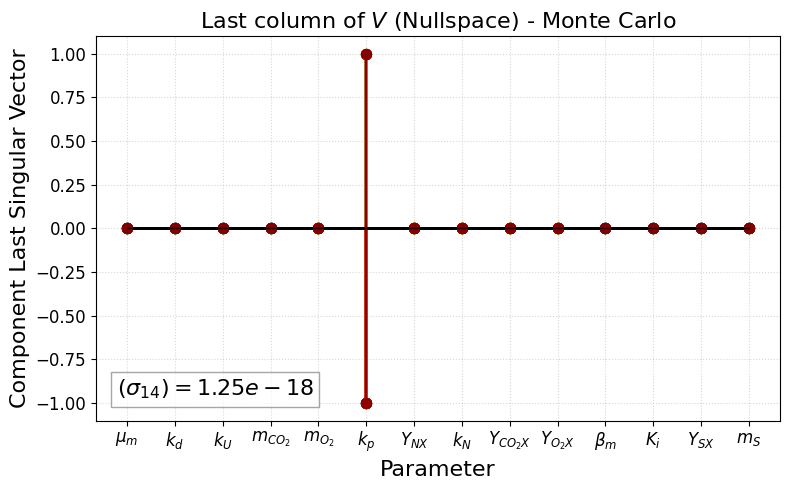

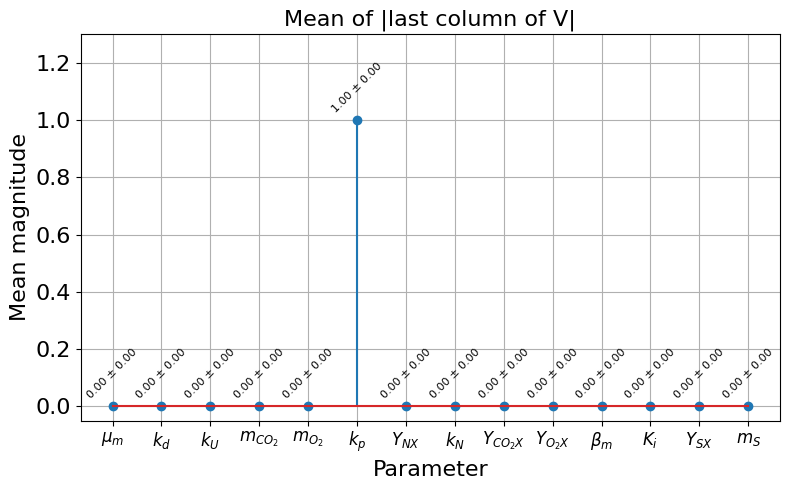

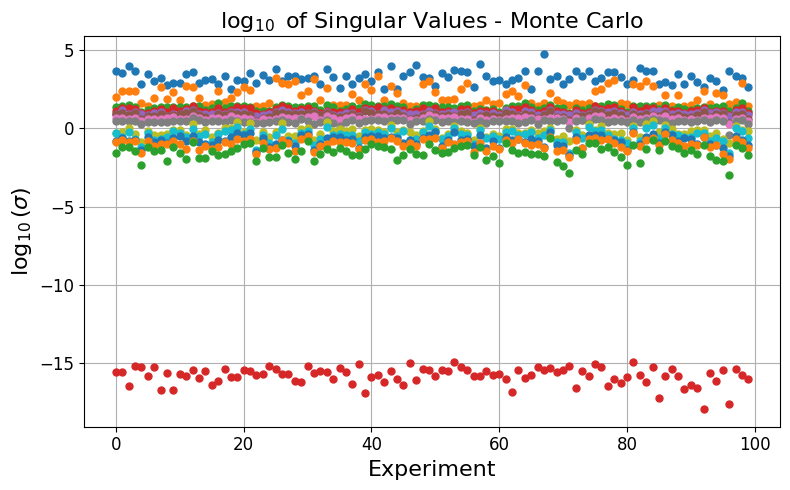

In [ ]:
# Compute mean and standard deviation of nullspace components
mean_v = np.mean(np.abs(V_last_cols), axis=1)
std_v = np.std(np.abs(V_last_cols), axis=1)
min_sigma = np.min(SingularValues[:, -1])
max_sigma = np.max(SingularValues[:, 0])

# === Plot: Last column of V for each experiment ===
param_names = [
    r'$\mu_m$',     # Maximum specific growth rate
    r'$k_d$',       # Dead rate
    r'$k_U$',       # Urea/Nitrogen yield coefficient
    r'$m_{CO_2}$',  # CO2 maintenance coefficient
    r'$m_{O_2}$',   # O2 maintenance coefficient
    r'$k_p$',       # GA3 degradation rate
    r'$Y_{NX}$',    # Nitrogen/Biomass yield coefficient
    r'$k_N$',       # Nitrogen saturation constant
    r'$Y_{CO_2X}$', # CO2/Biomass yield coefficient
    r'$Y_{O_2X}$',  # O2/Biomass yield coefficient
    r'$\beta_m$',   # Max GA3 production rate
    r'$K_i$',       # Substrate inhibition constant
    r'$Y_{SX}$',    # Substrate/Biomass yield
    r'$m_S$'        # Substrate maintenance coefficient
]

x_vals = np.arange(nth)
colors = plt.cm.jet(np.linspace(0, 1, NExp))

plt.figure(figsize=(8, 5))
for k in range(NExp):
    v_last = V_last_cols[:, k]
    markerline, stemlines, baseline = plt.stem(
        x_vals, v_last,
        linefmt='-', markerfmt='o', basefmt='k-',
        label=f'Exp {k+1}'
    )
    plt.setp(markerline, color=colors[k], markersize=7, alpha=0.8)
    plt.setp(stemlines, color=colors[k], linewidth=1.6, alpha=0.8)
    plt.setp(baseline, color='k', linewidth=1.0, alpha=0.7)

plt.xticks(x_vals, param_names, rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.title(r"Last column of $V$ (Nullspace) - Monte Carlo", fontsize=16)
plt.xlabel("Parameter", fontsize=16)
plt.ylabel(r"Component Last Singular Vector", fontsize=16)
plt.ylim(-1.1, 1.1)
plt.grid(True, linestyle=':', alpha=0.5)

plt.text(
    0.03, 0.05,
    rf'$(\sigma_{{{nth}}}) = {min_sigma:.2e}$',
    fontsize=16,
    transform=plt.gca().transAxes,
    ha='left', va='bottom',
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7)
)

plt.tight_layout()
plt.show()

# === Plot: Mean of |last column of V| ===
plt.figure(figsize=(8, 5))
plt.stem(mean_v)
plt.xticks(x_vals, param_names, rotation=0, fontsize=12)
plt.yticks(fontsize=16)
for i in range(nth):
    plt.text(
        i, mean_v[i] + 0.02,
        f"{mean_v[i]:.2f} ± {std_v[i]:.2f}",
        ha='center', va='bottom',
        fontsize=8,
        rotation=45
    )

plt.title("Mean of |last column of V|", fontsize=16)
plt.xlabel("Parameter", fontsize=16)
plt.ylabel("Mean magnitude", fontsize=16)
plt.ylim(-0.05, 1.3)
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot: log10 of singular values across experiments ===
plt.figure(figsize=(8, 5))
plt.plot(np.log10(SingularValues), '.', markersize=10)
plt.title(r"$\log_{10}$ of Singular Values - Monte Carlo", fontsize=16)
plt.xlabel("Experiment", fontsize=16)
plt.ylabel(r"$\log_{10}(\sigma)$", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## Simulation vs Experimental Data

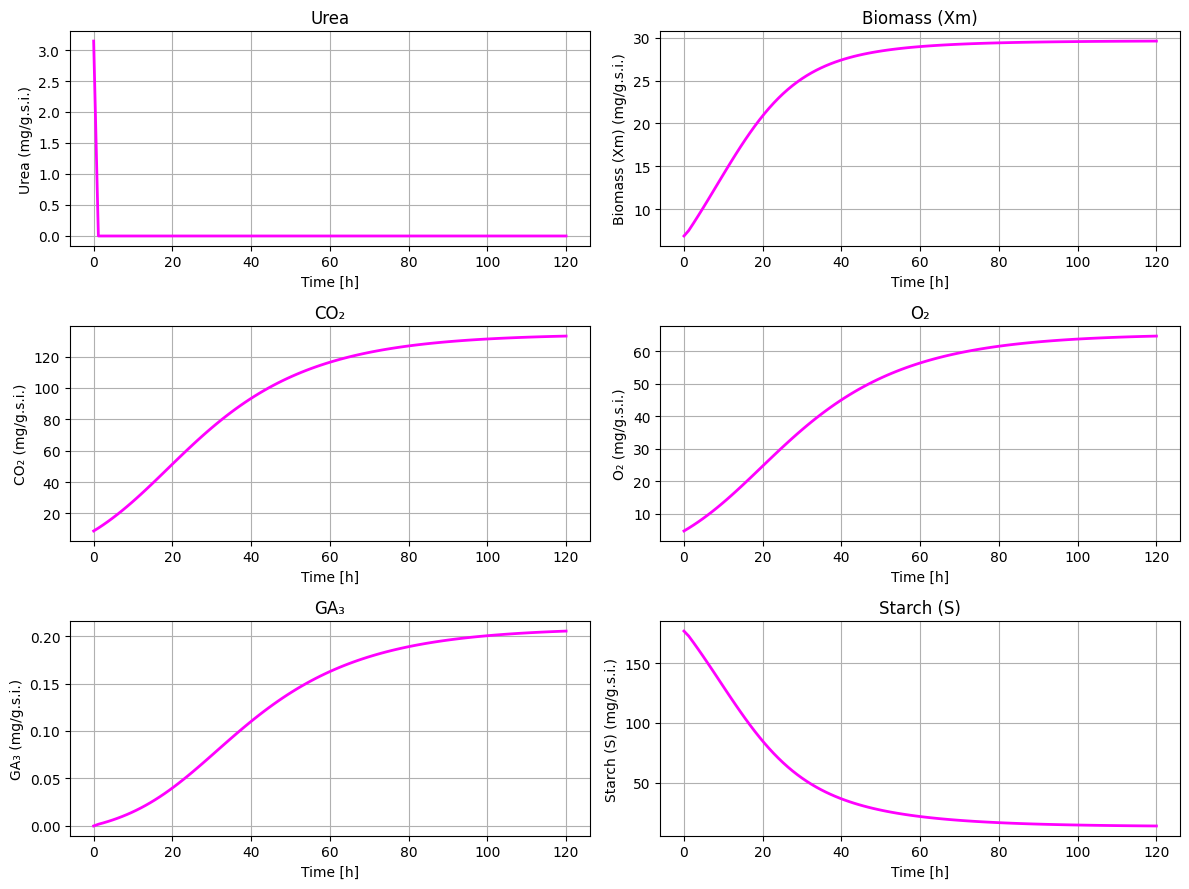

In [ ]:
t_out, x_out, dx_dth_out = simulate_once(theta_nom)
y_out_mg = y_out * 1000  # Convert g/g.s.i. → mg/g.s.i.
# Etiquetas y orden como HIPPO
observed_indices = [1, 3, 4, 5, 6, 7]
observed_labels = ['Urea', 'Biomass (Xm)', 'CO₂', 'O₂', 'GA₃', 'Starch (S)']
units = 'mg/g.s.i.'

# Convertir resultados a mg/g.s.i.
_, _, y_out = compute_dydth(x_out, dx_dth_out, theta_nom)
y_out_mg = y_out * 1000

# Plot 3x2 estilo HIPPO con unidades corregidas
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(12, 9))
axs = axs.flatten()

for i in range(6):
    axs[i].plot(t_out, y_out_mg[:, i], color='magenta', linewidth=2)
    axs[i].set_title(observed_labels[i])
    axs[i].set_xlabel("Time [h]")
    axs[i].set_ylabel(f"{observed_labels[i]} ({units})")
    axs[i].grid(True)

plt.tight_layout()
plt.show()


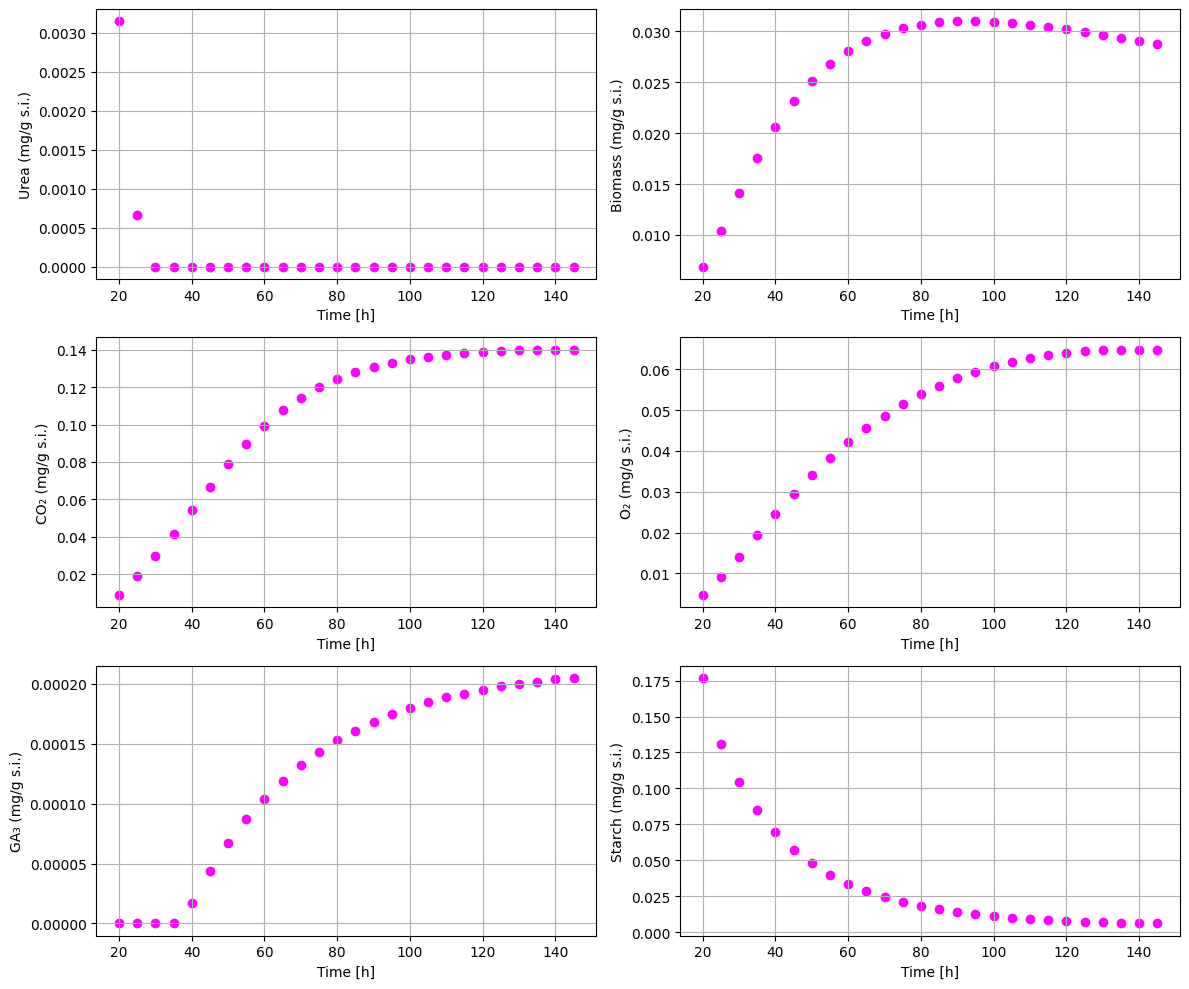

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Leer archivo
data_file = 'ssf_25_999.txt'
df = pd.read_csv(data_file, sep='\s+', header=None)
df.columns = ["Time_h", "Urea", "Biomass", "CO2", "O2", "GA3", "Starch"]
df = df.astype(float)

# Extraer variables
t_exp      = df["Time_h"].to_numpy()
urea_exp   = df["Urea"].to_numpy()
biomass    = df["Biomass"].to_numpy()
co2        = df["CO2"].to_numpy()
o2         = df["O2"].to_numpy()
ga3        = df["GA3"].to_numpy()
starch     = df["Starch"].to_numpy()

# Gráfico 3x2 con puntos
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

axs[0, 0].scatter(t_exp, urea_exp, color='magenta', label="Urea")
axs[0, 0].set_ylabel("Urea (mg/g s.i.)")

axs[0, 1].scatter(t_exp, biomass, color='magenta', label="Biomass")
axs[0, 1].set_ylabel("Biomass (mg/g s.i.)")

axs[1, 0].scatter(t_exp, co2, color='magenta', label="CO₂")
axs[1, 0].set_ylabel("CO₂ (mg/g s.i.)")

axs[1, 1].scatter(t_exp, o2, color='magenta', label="O₂")
axs[1, 1].set_ylabel("O₂ (mg/g s.i.)")

axs[2, 0].scatter(t_exp, ga3, color='magenta', label="GA₃")
axs[2, 0].set_ylabel("GA₃ (mg/g s.i.)")

axs[2, 1].scatter(t_exp, starch, color='magenta', label="Starch")
axs[2, 1].set_ylabel("Starch (mg/g s.i.)")

# Estética común
for ax in axs.flat:
    ax.set_xlabel("Time [h]")
    ax.grid(True)

plt.tight_layout()
plt.show()

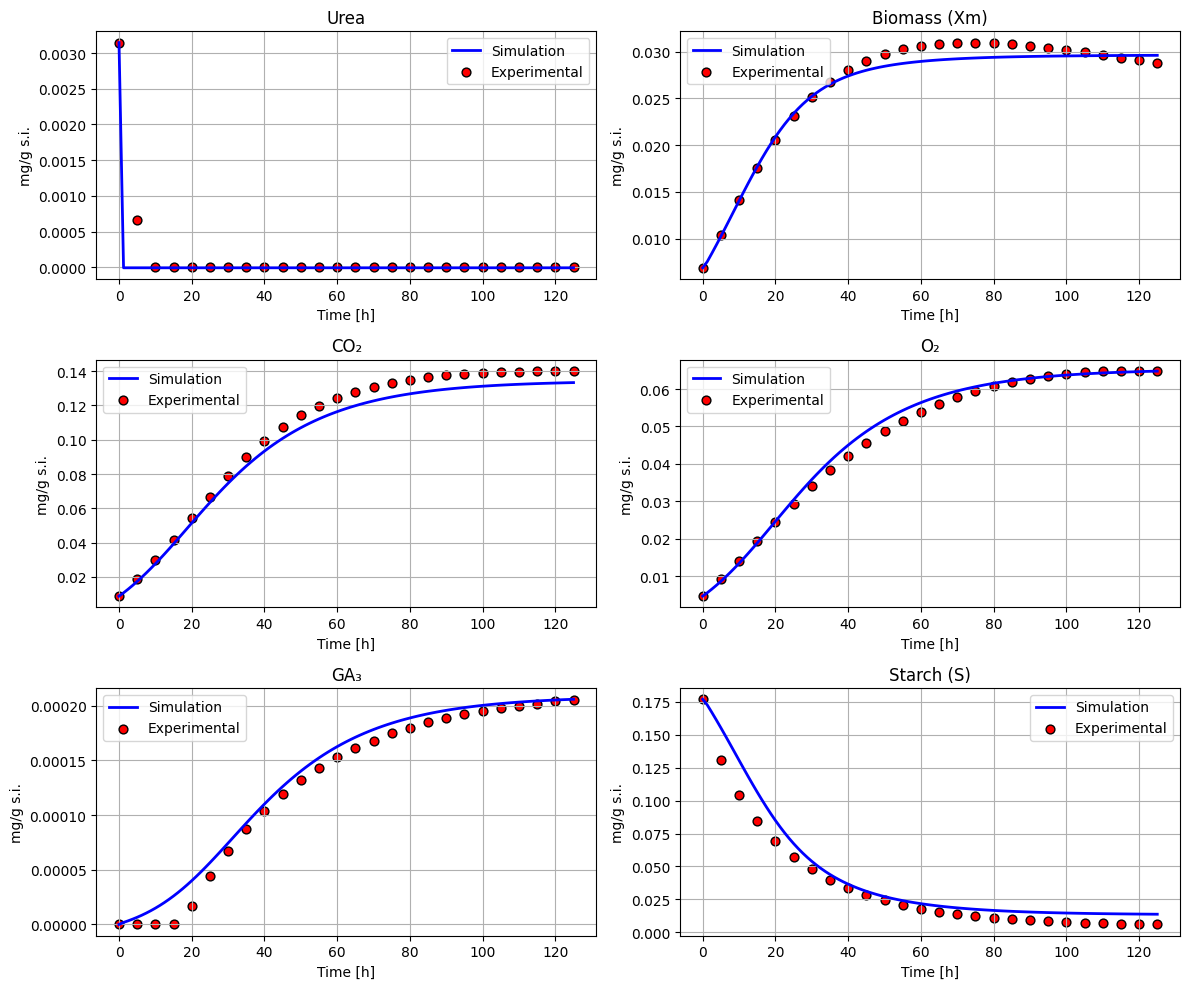

In [ ]:
# === Build experimental matrix ===
exp_data = np.column_stack([urea_exp, biomass, co2, o2, ga3, starch])

# === Align experimental time ===
t_exp_shifted = t_exp - t_exp[0]  # Shift so that t=20 → t=0

# === Run simulation (unscaled output) ===
t_out, x_out, dx_dth_out = simulate_once(theta_nom)
_, _, y_out = compute_dydth(x_out, dx_dth_out, theta_nom)
y_out_mg = y_out  # already in mg/g s.i.

# === Combined plot: Experimental vs Simulation ===
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()
observed_labels = ['Urea', 'Biomass (Xm)', 'CO₂', 'O₂', 'GA₃', 'Starch (S)']

for i in range(6):
    # Simulated trajectory
    axs[i].plot(t_out, y_out_mg[:, i], color='blue', linewidth=2, label='Simulation')

    # Experimental points
    axs[i].scatter(t_exp_shifted, exp_data[:, i],
                   color='red', s=40, edgecolors='black', label='Experimental')

    axs[i].set_title(observed_labels[i])
    axs[i].set_xlabel("Time [h]")
    axs[i].set_ylabel("mg/g s.i.")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()